https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html

## Goal

* Harris Corner Detection 이해하기

* CV로 구현하기, Karnia로 구현하기

![nn](data/harris_a.png)
![nn](data/harris_b.png)

## Using OpenCV

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img shape:  (612, 612, 3)


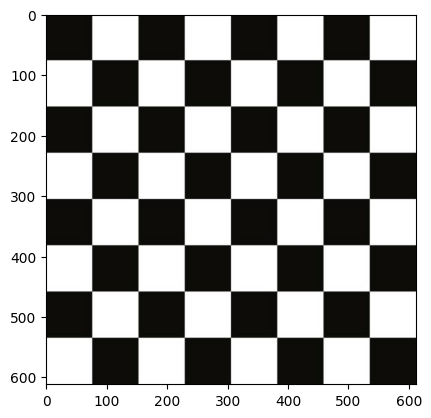

In [2]:
filename = 'data/chessboard.jpg'
img = cv.imread(filename)

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)

print("img shape: ",img.shape)
plt.imshow(img)
plt.show()

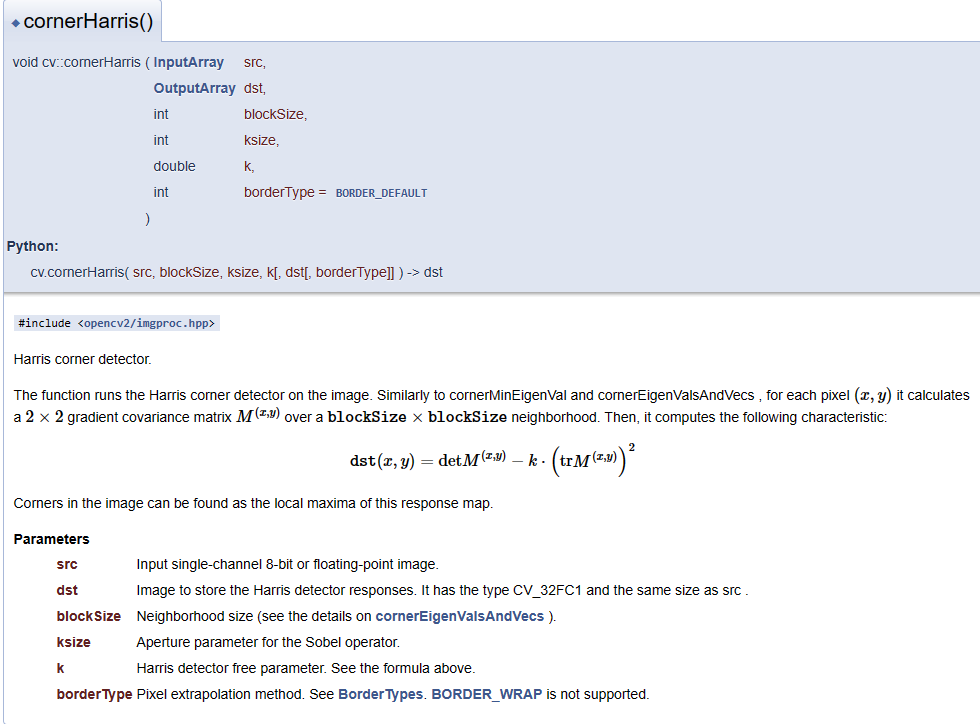

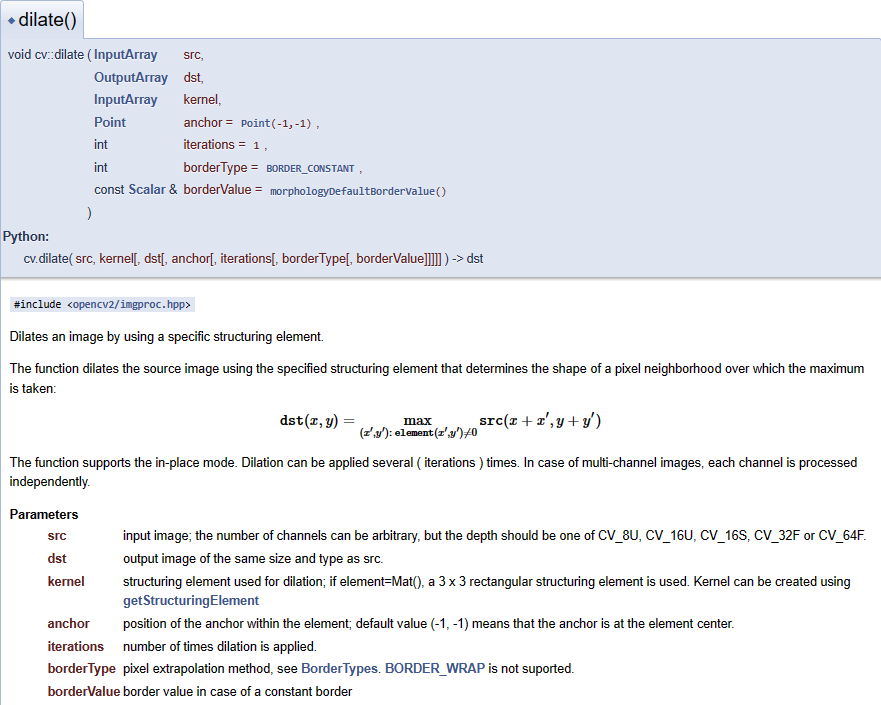

In [3]:
dst = cv.cornerHarris(gray, 2, 3, 0.04)
dst = cv.dilate(dst,None)

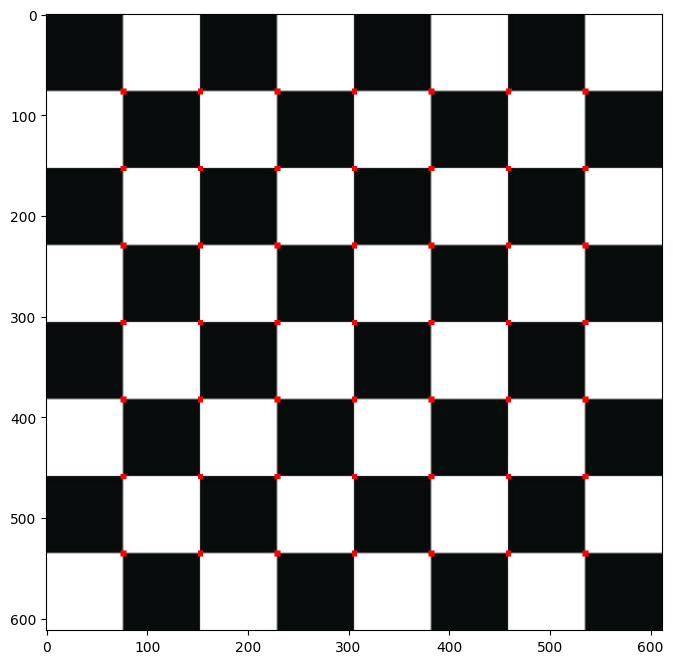

In [4]:
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

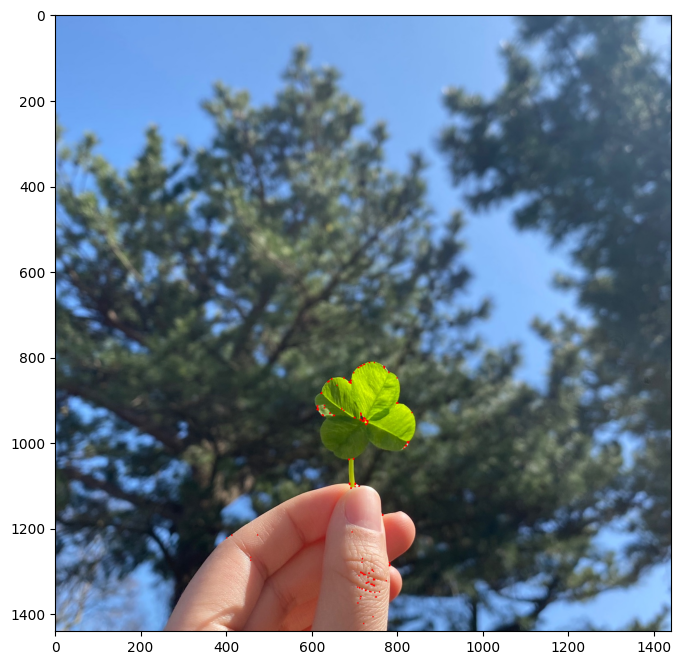

In [5]:
filename = 'data/image.jpeg'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)

#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(15,8))
plt.imshow(img[:,:,::-1])
plt.show()

## Using Kornia library

https://kornia.readthedocs.io/en/latest/_modules/kornia/feature/responses.html

In [6]:
import torch
from torchvision import transforms

from PIL import Image

filename = 'data/chessboard.jpg'

In [7]:
np.shape(Image.open(filename))

(612, 612, 3)

In [8]:
np.shape((Image.open(filename).convert('L')))

(612, 612)

In [9]:
transforms.ToTensor()(Image.open(filename).convert('L')).shape

torch.Size([1, 612, 612])

In [10]:
transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0).shape

torch.Size([1, 1, 612, 612])

torch.Size([1, 1, 612, 612])


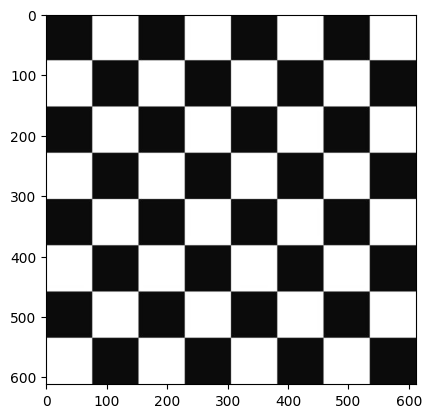

In [11]:
tensor = transforms.ToTensor()(Image.open(filename).convert('L')).unsqueeze(0)
print(tensor.shape)

plt.imshow(tensor.squeeze(), cmap='gray')
plt.show()

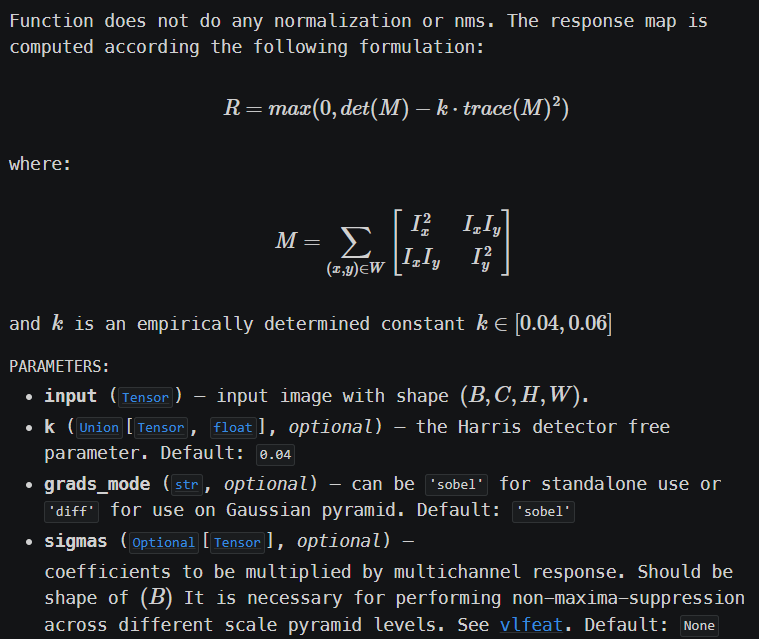
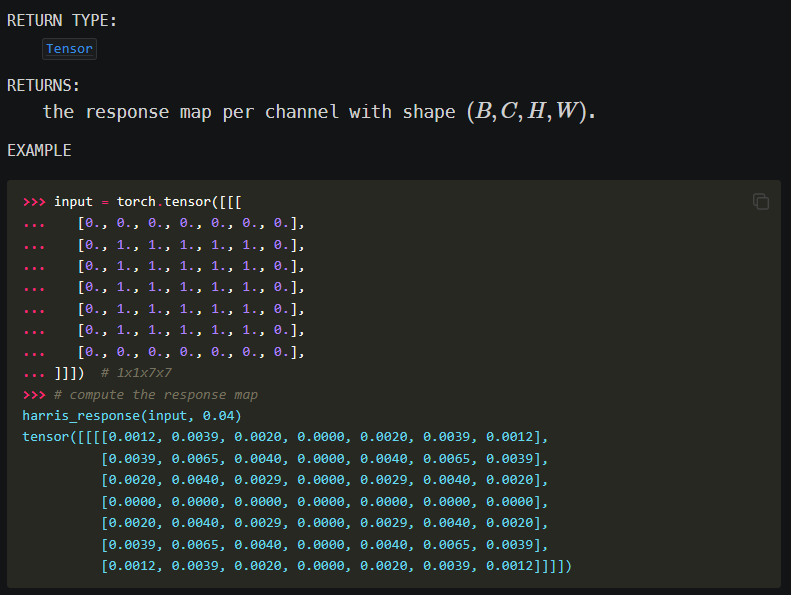

In [23]:
import kornia
import kornia.feature as KF
from kornia import tensor_to_image as tti

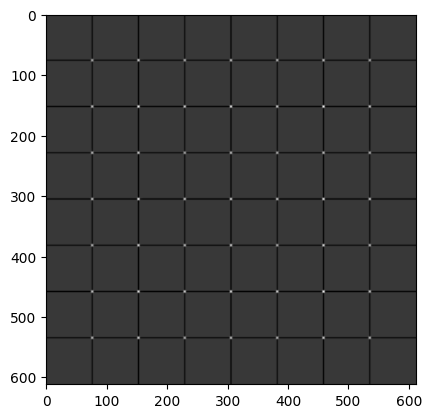

In [19]:
harris = KF.responses.CornerHarris(0.05) 

cornerness = harris(tensor)
plt.imshow(cornerness.squeeze(), cmap='gray')
plt.show()

## (심화) Example on the scale pyramid, Blob

In [20]:
filename = 'data/siemens.png' # # filename = 'image.jpeg'
img = Image.open(filename)
np.shape(img)

(800, 800)

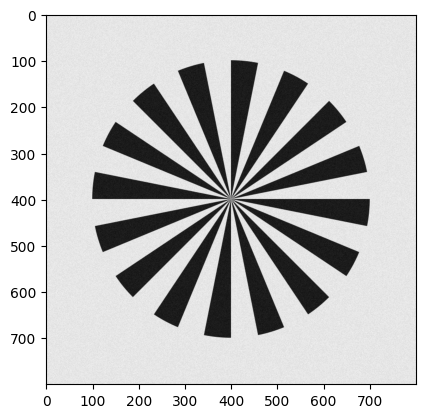

In [21]:
timg = kornia.utils.image_to_tensor(np.array(img), keepdim=False).float() / 255.  / 255.  #This specific image somehow has [0, 255**2] range
plt.imshow(kornia.utils.tensor_to_image(timg[0]), 'gray')

7 torch.Size([1, 1, 6, 800, 800])


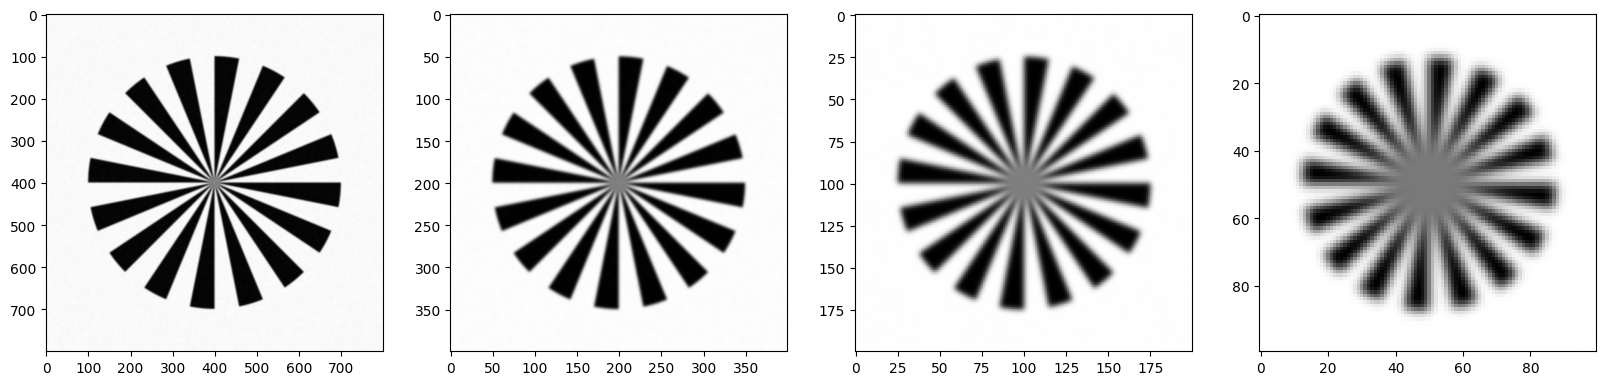

In [24]:
resp = kornia.feature.responses.CornerHarris(0.05)  # CornerHarris 

SP = kornia.geometry.ScalePyramid(3, 1.6, 10) #

pyr, sigmas, scales = SP(timg)
print (len(pyr), pyr[0].shape)

fig, axes = plt.subplots(1,4, figsize=(20,8))

ax = axes[0]
ax.imshow(tti(pyr[0][0,0,0]), 'gray')
ax = axes[1]
ax.imshow(tti(pyr[1][0,0,0]), 'gray')
ax = axes[2]
ax.imshow(tti(pyr[2][0,0,0]), 'gray')
ax = axes[3]
ax.imshow(tti(pyr[3][0,0,0]), 'gray')
current_level = pyr[1]

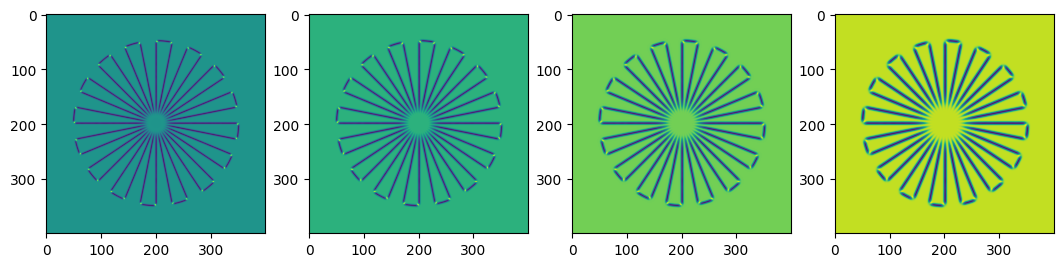

In [25]:
fig, axes = plt.subplots(1,4, figsize=(13,6))

cornerness = resp(current_level[0])
for i in range(4):
    ax = axes[i]
    ax.imshow(tti(cornerness[0,i]))

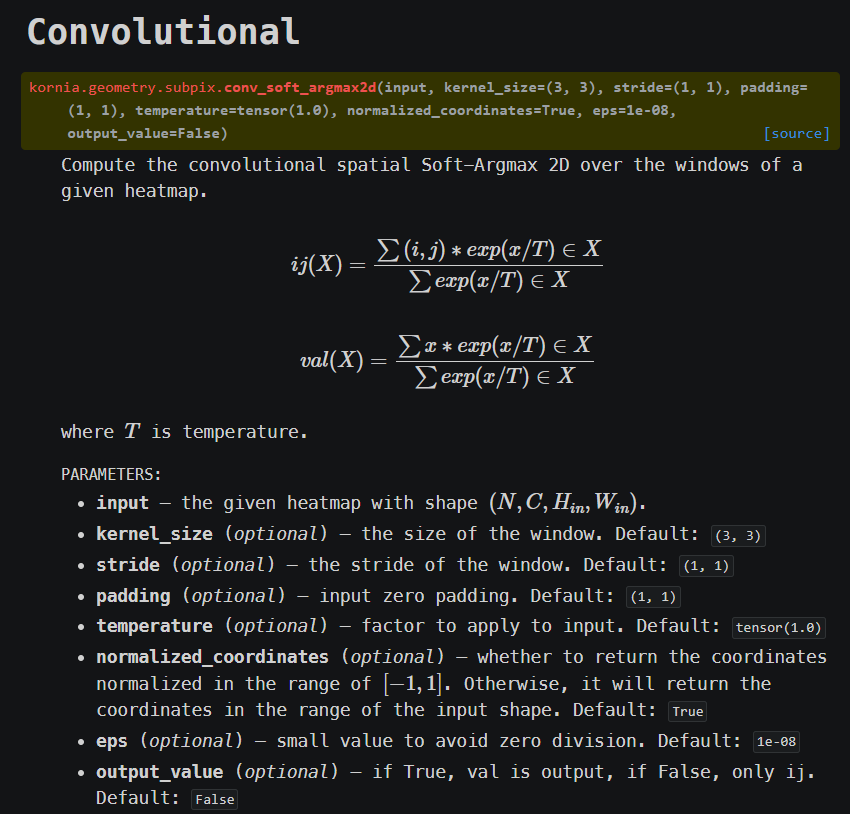
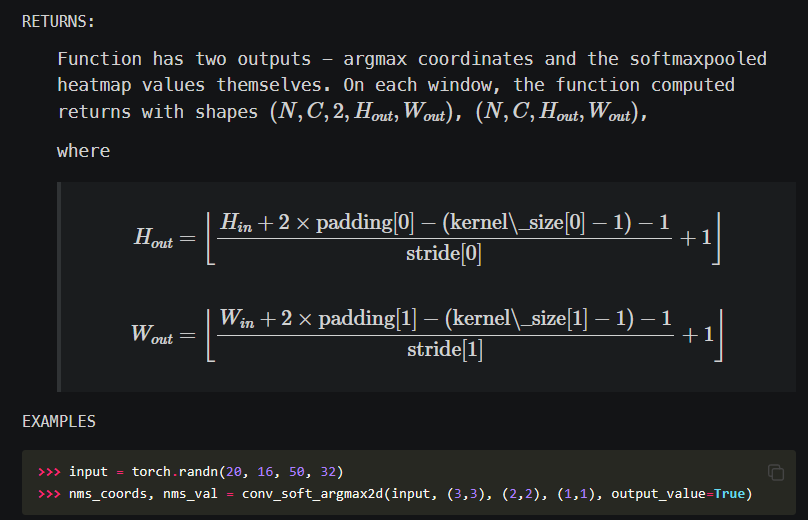

In [26]:
## The next component is detector of the maximum of the local responce: ConvQuadInterp3d(), 
## which does quadratic interpolation of the location, or ConvSoftArgmax3d, 
## which does softargmax estimation of the location.

nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), # nms windows size (scale, height, width)
                                       stride=(1,1,1), # stride (scale, height, width)
                                       padding=(1, 1, 1),
                                       temperature=0.1) # nms windows size (scale, height, width)

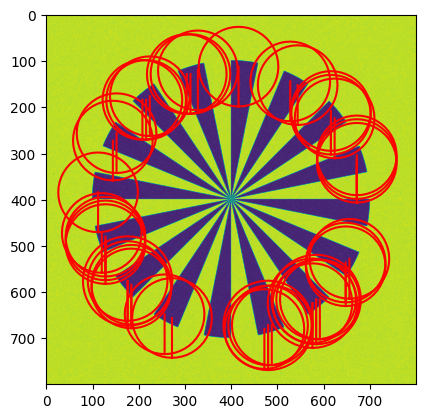

torch.Size([1, 40, 2, 3])
tensor([[[ 86.2059,   0.0000, 575.9996],
         [  0.0000,  86.2059, 624.0004]],

        [[ 86.2057,   0.0000, 143.9996],
         [  0.0000,  86.2057, 272.0005]],

        [[ 86.2054,   0.0000, 151.9999],
         [  0.0000,  86.2054, 255.9997]]])


In [27]:
# local affine resion
def visualize_LAF(img, LAF, img_idx = 0):
    x, y = kornia.feature.laf.get_laf_pts_to_draw(LAF, img_idx)
    plt.figure()
    plt.imshow(kornia.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

#Lets detect Harris corners
n_feats = 40
mr_size = 6.0 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, # 몇개의 point 를 detect
                                    resp_module=resp, # corner 를 찾을 알고리즘
                                    nms_module=nms1, # nms 알고리즘
                                    mr_size=mr_size) # size

lafs, resps = harris_local_detector(timg)

visualize_LAF(timg, lafs)
print(lafs.shape)
print(lafs[0,:3])

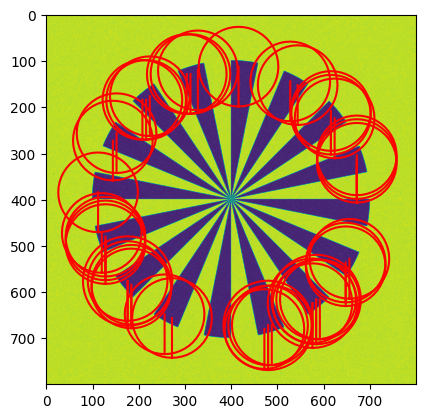

torch.Size([1, 40, 2, 3])


In [28]:
#n_feats = 40
mr_size = 6.0 
nms1 = kornia.geometry.ConvSoftArgmax3d(kernel_size=(3,3,3), 
                                       stride=(1,1,1), 
                                       padding=(1, 1, 1),
                                       temperature=0.1,
                                       strict_maxima_bonus=100.) # nms windows size (scale, height, width) 조절

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms1,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg, lafs)
print(lafs.shape)

생각보다 duplication 제거가 잘 안된다.

따라서, quadrative interpolation 3D 를 통해 subpixel 수준에서의 non-maximal suppression을 한 번 더 수행한다.

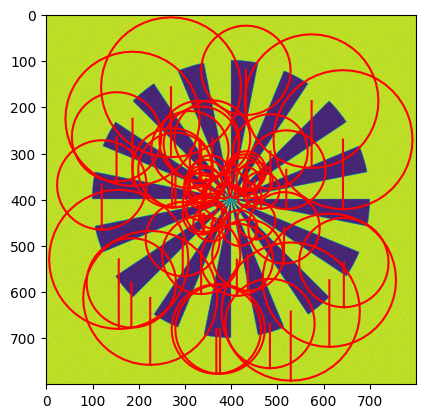

In [29]:
#Lets detect Harris corners w/o duplicates
n_feats = 50
mr_size = 6.0 
nms = kornia.geometry.ConvQuadInterp3d(10, 2e-4) 

harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size)

lafs, resps = harris_local_detector(timg)
visualize_LAF(timg,lafs)

Harris 가 아니라 다른 affine 모듈 (e.g., DoG 나 LoG를 사용)의 적용

scale-space detector에 shape estimator를 넣어서 실행.

/tmp/ipykernel_215/1809961612.py:10: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19), # 별도의 aff_module 을 넣어줌


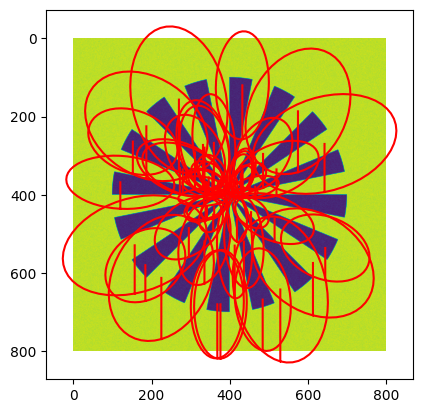

In [30]:
# harris_local_detector = KF.ScaleSpaceDetector(n_feats, 
#                                     resp_module=resp,
#                                     nms_module=nms,
#                                     mr_size=mr_size)

harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=resp,
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19), # 별도의 aff_module 을 넣어줌
                                    minima_are_also_good=False)

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

Feature orientation estimator 도 추가 가능

/tmp/ipykernel_215/4236782469.py:6: DeprecationWarning: `LAFAffineShapeEstimator` default behaviour is changed and now it does preserve original LAF orientation. Make sure your code accounts for this.
  aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),


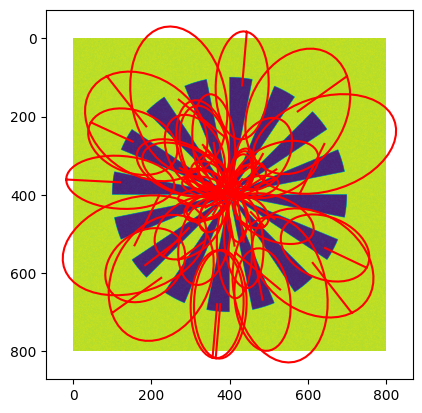

In [31]:
# Now lets also detect feature orientation
harris_affine_local_detector = KF.ScaleSpaceDetector(n_feats, 
                                    resp_module=kornia.feature.CornerHarris(0.05),
                                    nms_module=nms,
                                    mr_size=mr_size,
                                    aff_module=kornia.feature.LAFAffineShapeEstimator(patch_size=19),
                                    ori_module=kornia.feature.LAFOrienter(patch_size=19)) # Orienter를 따로 넣어서 방향성 정보도 visualizaion 가능

lafs, resps = harris_affine_local_detector(timg)
visualize_LAF(timg,lafs)

하지만 patch 중 몇몇은 image를 벗어나는 문제가 있음

## Obtain patch descriptor using the obtained affine regions

shift를 하여 patch를 추출

In [32]:
#Lets describe patches with SIFT descriptor
descriptor = KF.SIFTDescriptor(32)

patches =  kornia.feature.extract_patches_from_pyramid(timg, lafs)
B, N, CH, H, W = patches.size()
# Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
# So we need to reshape a bit :) 
descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
print (descs.shape)
print (descs[0, 0])

torch.Size([1, 50, 128])
tensor([1.7122e-01, 1.9694e-01, 8.8489e-02, 2.3893e-02, 1.9694e-01, 1.9694e-01,
        5.1885e-02, 1.2669e-01, 1.4272e-01, 1.8941e-01, 5.9256e-02, 8.3687e-03,
        1.4653e-02, 9.3539e-03, 8.8716e-03, 8.2934e-03, 1.3615e-01, 1.8896e-02,
        1.1053e-03, 3.3802e-03, 1.5954e-01, 6.2045e-03, 8.4509e-02, 1.3792e-01,
        1.1736e-01, 1.7033e-01, 8.5038e-02, 7.1409e-02, 2.0141e-02, 3.2950e-02,
        1.2828e-02, 1.0850e-02, 3.9233e-02, 1.2718e-02, 4.7950e-02, 1.3633e-01,
        1.0000e-05, 1.9626e-03, 6.4905e-02, 6.8569e-02, 5.5713e-02, 1.6965e-01,
        1.0413e-01, 4.2805e-02, 3.7189e-02, 6.0008e-02, 1.0002e-02, 8.3240e-03,
        2.2160e-02, 1.6060e-01, 1.3629e-01, 1.9694e-01, 1.2338e-02, 7.1886e-02,
        1.9694e-01, 5.0726e-02, 5.8153e-02, 5.6867e-02, 1.0131e-01, 8.1437e-03,
        2.1741e-02, 1.4990e-02, 6.3266e-03, 7.6904e-03, 1.7731e-01, 1.9042e-01,
        9.2191e-02, 1.5439e-02, 1.8790e-01, 1.7959e-01, 1.8229e-01, 4.3414e-03,
        1.7916e

### Reference 

https://kornia.readthedocs.io/en/latest/feature.html

https://github.com/kornia/kornia-examples/blob/master/local_feature_detection_example.ipynb